<a href="https://colab.research.google.com/github/Euzoka95/PDA2024/blob/main/IT7103_Lab_4_EUzoka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: load the dataset

In [1]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# Load dataset
file_path = '/content/drive/My Drive/breast-cancer.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
print(data.head())

Mounted at /content/drive
        ID  ClumpThickness  UniformityOfCellSize  UniformityOfCellShape  \
0  1000025               5                     1                      1   
1  1002945               5                     4                      4   
2  1015425               3                     1                      1   
3  1016277               6                     8                      8   
4  1017023               4                     1                      1   

   MarginalAdhesion  SingleEpithelialCellSize  BareNuclei  BlandChromatin  \
0                 1                         2           1               3   
1                 5                         7          10               3   
2                 1                         2           2               3   
3                 1                         3           4               3   
4                 3                         2           1               3   

   NormalNucleoli  Mitoses  Class  
0               1       

Step 2: we import neccesary libraries, define the features and target and display visualization of the numerical features using Histogtrams

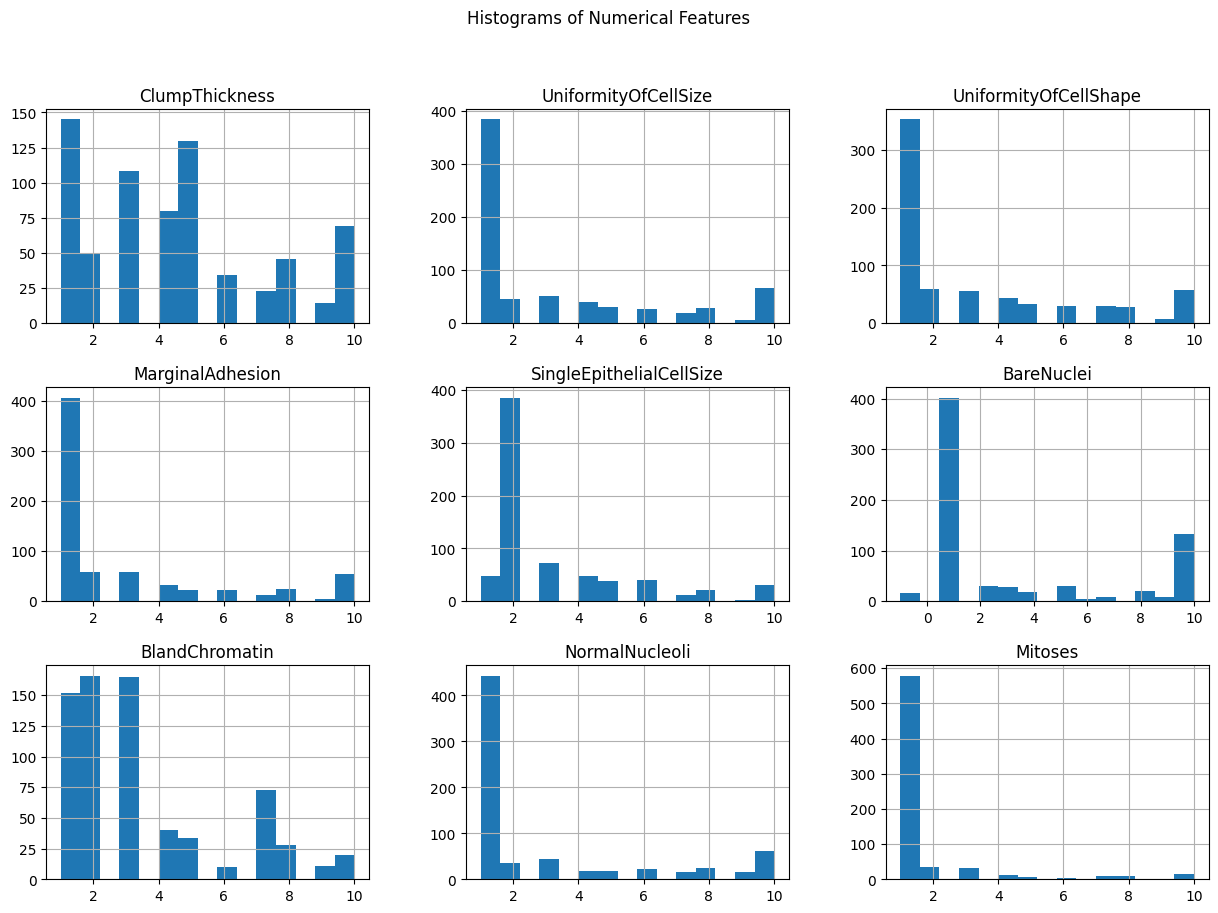

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Define features and target
features = ['ClumpThickness', 'UniformityOfCellSize', 'UniformityOfCellShape',
            'MarginalAdhesion', 'SingleEpithelialCellSize', 'BareNuclei',
            'BlandChromatin', 'NormalNucleoli', 'Mitoses']
target = 'Class'

# Plot histograms for numerical features
data[features].hist(bins=15, figsize=(15, 10), layout=(3, 3))
plt.suptitle('Histograms of Numerical Features')
plt.show()




Step 3: We prepare the dataset, build and train the SVM Model

In [8]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Split dataset into train and test sets
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Display the shape of train and test sets
#print(f"Training set shape: {train.shape}")
#print(f"Testing set shape: {test.shape}")

# Define preprocessing pipeline for numerical features
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# Combine preprocessing steps (all features are numerical in this case)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, features)
])

# Separate features and target
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Define the SVM model pipeline
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear'))
])

# Train the model
svm_pipeline.fit(X_train, y_train)

# Display the first few rows of the processed training data
X_train_processed = preprocessor.fit_transform(X_train)
print("First few rows of the processed training data:")
print(pd.DataFrame(X_train_processed, columns=features).head())

# Evaluate the model
train_accuracy = svm_pipeline.score(X_train, y_train)
test_accuracy = svm_pipeline.score(X_test, y_test)

print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Testing Accuracy: {test_accuracy:.2f}')



First few rows of the processed training data:
   ClumpThickness  UniformityOfCellSize  UniformityOfCellShape  \
0        0.164886             -0.383175              -0.760698   
1        0.164886             -0.054655              -0.096276   
2       -1.236959             -0.711694              -0.760698   
3        0.164886             -0.711694              -0.760698   
4       -0.886498             -0.711694              -0.096276   

   MarginalAdhesion  SingleEpithelialCellSize  BareNuclei  BlandChromatin  \
0         -0.642507                 -0.554964   -0.681273       -0.183205   
1          0.405629                 -0.554964    0.122735       -0.183205   
2         -0.293128                 -0.554964   -0.681273       -0.183205   
3         -0.642507                 -0.554964   -0.681273       -0.586401   
4         -0.293128                 -0.554964   -0.681273       -0.586401   

   NormalNucleoli   Mitoses  
0       -0.601492 -0.349724  
1        0.392303 -0.349724  
2  

Step 4: It seems the model is performing very well, to ensure that the model is not overfitting, we can perform cross-validation and hyperparameter tuning with GridSearchCV and then we plot a confusion matrix, to provide a detailed breakdown of the classification performance of our SVM model

Training Accuracy: 0.97
Testing Accuracy: 0.97
Best Parameters: {'classifier__C': 1, 'classifier__degree': 2, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}


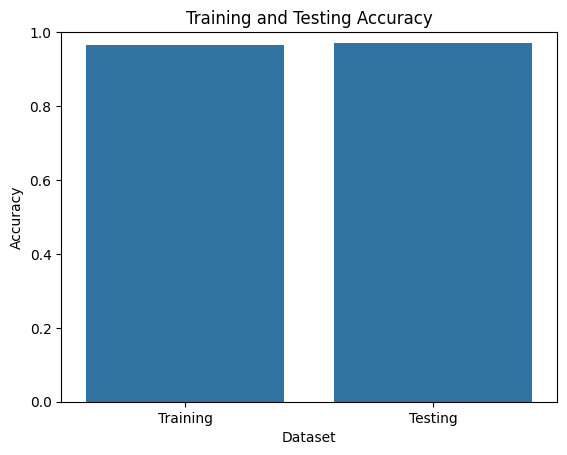

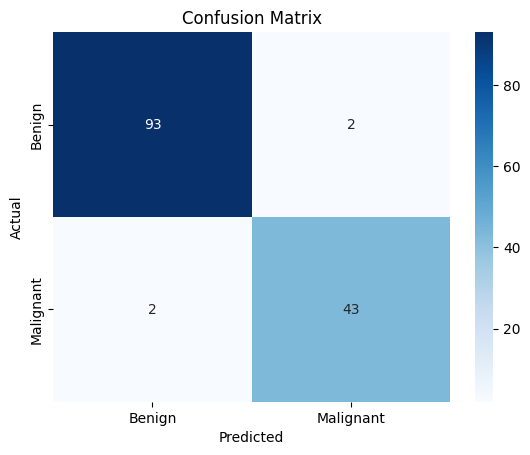

In [12]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'poly', 'rbf'],
    'classifier__degree': [2, 3, 4],  # Only for 'poly' kernel
    'classifier__gamma': [0.001, 0.01, 0.1, 1, 10]  # Only for 'rbf' kernel
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Training accuracy
train_accuracy = best_model.score(X_train, y_train)
print(f'Training Accuracy: {train_accuracy:.2f}')

# Testing accuracy
test_accuracy = best_model.score(X_test, y_test)
print(f'Testing Accuracy: {test_accuracy:.2f}')

# Best parameters from the grid search
print(f"Best Parameters: {grid_search.best_params_}")

# Plot training and testing accuracy
accuracy_df = pd.DataFrame({
    'Dataset': ['Training', 'Testing'],
    'Accuracy': [train_accuracy, test_accuracy]
})
sns.barplot(x='Dataset', y='Accuracy', data=accuracy_df)
plt.title('Training and Testing Accuracy')
plt.ylim(0, 1)
plt.show()

# Visualize confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
